Name: Aparna Iyer

PRN: 22070126017

Branch: AI-ML

Batch: 2022-2026, A1

###**Title: Deep Convolutional GANs**

Deep Convolutional Generative Adversarial Networks (DCGANs) are an advanced type of GANs that utilize convolutional layers for improved image generation. Introduced by Radford et al. (2016),DCGANs provide a more stable training process and generate higher-quality images compared to
vanilla GANs.

The key architectural guidelines for DCGANs include:

1. **Replacing Fully Connected Layers**: Instead of dense layers, DCGANs use convolutional and
   transposed convolutional layers for better spatial understanding.
2. **Using Batch Normalization**: Applied in both the Generator and Discriminator (except the
   input layer of Discriminator and output layer of Generator) to stabilize training.
3. **LeakyReLU in Discriminator**: Helps prevent dying gradients and ensures smooth training.
4. **ReLU in Generator**: Used for all layers except the output, where Tanh is applied.
5. **Strided Convolutions**: Used instead of pooling layers to downsample in the Discriminator
   and Fractionally-Strided Convolutions (Transpose Convolutions) to upsample in the Generator.

This implementation follows these guidelines while training DCGAN on the CIFAR-10 dataset.

**Import the necessary libraries.**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Set the hyperparameters:**

channels: Number of Input Channels

Learning Rate, Alpha: 0.0002

Number of Epochs: 25


In [3]:
# Hyperparameters
latent_dim = 100  # Size of the noise vector
image_size = 32
channels = 3
batch_size = 128
epochs = 25
lr = 0.0002
beta1 = 0.5

**Dataset Selected: CIFAR-10 Dataset**

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes. There are 6000 images per class, 50000 training images, and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1000 randomly-selected images from each class.

In [4]:
# Data Preprocessing & Loading CIFAR-10
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize between [-1,1]
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=data_transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 170M/170M [00:05<00:00, 28.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [15]:
# Visualizing some real images
def visualize_real_images():
    dataiter = iter(dataloader)
    images, _ = next(dataiter)
    images = (images + 1) / 2  # Denormalize to [0,1] range
    grid = torchvision.utils.make_grid(images[:8], nrow=4)
    np_img = grid.permute(1, 2, 0).numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(np_img)
    plt.axis("off")
    plt.title("Real Images from CIFAR-10")
    plt.show()

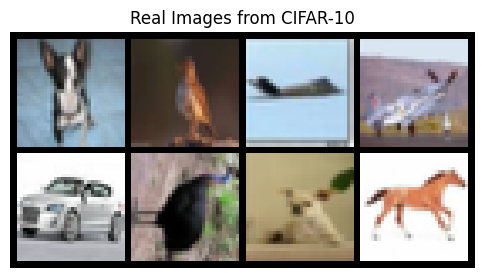

In [16]:
#Visualize the original real images from the CIFAR-10 Dataset
visualize_real_images()

In [5]:
# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, channels, 4, 2, 1, bias=False),
            nn.Tanh()  # Output range [-1,1]
        )

    def forward(self, z):
        return self.model(z)


In [6]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)

In [8]:
# Initialize models
generator = Generator().to(device) #Instantiate Generator Neural Network
discriminator = Discriminator().to(device) #Instantiate Discriminator Neural Network


In [9]:
# Loss and Optimizers
criterion = nn.BCELoss() #Binary Cross Entropy Loss for classification
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


In [10]:
# Training Loop
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)  # Fixed noise for evaluation

In [11]:
def train_dcgan():
    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Create real and fake labels
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # Train Discriminator
            optimizer_D.zero_grad()

            output_real = discriminator(real_images)
            loss_real = criterion(output_real, real_labels)

            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            loss_fake = criterion(output_fake, fake_labels)

            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            output_fake_gen = discriminator(fake_images)
            loss_G = criterion(output_fake_gen, real_labels)
            loss_G.backward()
            optimizer_G.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Step [{i}/{len(dataloader)}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

        # Save and visualize generated images after every epoch
        with torch.no_grad():
            fake_images = generator(fixed_noise).cpu()
        plot_generated_images(fake_images, epoch)

In [19]:
def plot_generated_images(images, epoch):
    images = (images + 1) / 2  # Denormalize to [0,1] range
    grid = torchvision.utils.make_grid(images, nrow=4)
    np_img = grid.permute(1, 2, 0).numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(np_img)
    plt.axis("off")
    plt.title(f"Generated Images at Epoch {epoch+1}")
    plt.show()
    plt.savefig(f"generated_epoch_{epoch+1}.png")  # Save the generated images


Epoch [1/25] Step [0/391] Loss D: 1.5189, Loss G: 3.1836
Epoch [1/25] Step [100/391] Loss D: 0.0465, Loss G: 8.7149
Epoch [1/25] Step [200/391] Loss D: 0.3003, Loss G: 4.9812
Epoch [1/25] Step [300/391] Loss D: 0.7422, Loss G: 1.5764


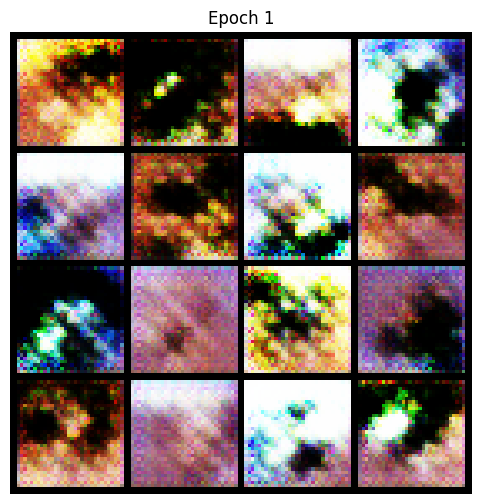

Epoch [2/25] Step [0/391] Loss D: 1.1507, Loss G: 1.5674
Epoch [2/25] Step [100/391] Loss D: 0.4871, Loss G: 3.3477
Epoch [2/25] Step [200/391] Loss D: 0.6019, Loss G: 2.9537
Epoch [2/25] Step [300/391] Loss D: 0.5865, Loss G: 2.7568


<Figure size 640x480 with 0 Axes>

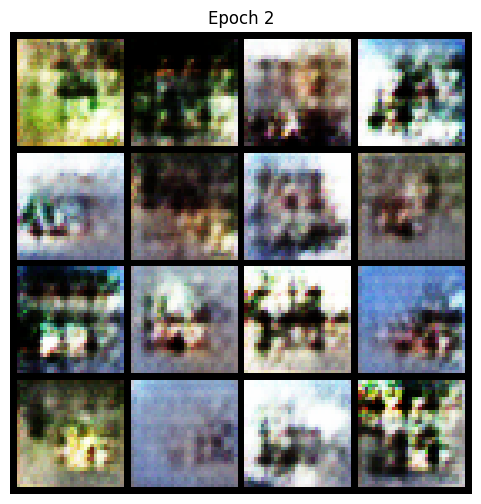

Epoch [3/25] Step [0/391] Loss D: 0.6724, Loss G: 3.0224
Epoch [3/25] Step [100/391] Loss D: 1.0685, Loss G: 3.3168
Epoch [3/25] Step [200/391] Loss D: 0.8445, Loss G: 1.9701
Epoch [3/25] Step [300/391] Loss D: 0.4634, Loss G: 3.4790


<Figure size 640x480 with 0 Axes>

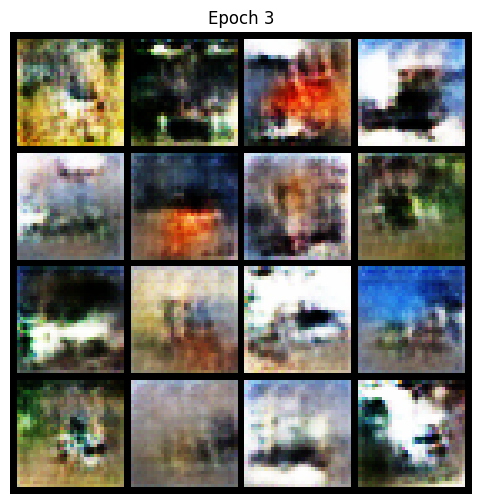

Epoch [4/25] Step [0/391] Loss D: 0.4926, Loss G: 2.9231
Epoch [4/25] Step [100/391] Loss D: 0.3422, Loss G: 2.8746
Epoch [4/25] Step [200/391] Loss D: 0.4220, Loss G: 2.8298
Epoch [4/25] Step [300/391] Loss D: 0.2962, Loss G: 2.5956


<Figure size 640x480 with 0 Axes>

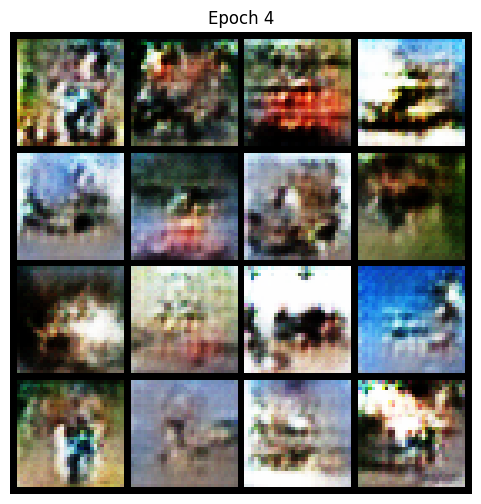

Epoch [5/25] Step [0/391] Loss D: 1.1153, Loss G: 5.0553
Epoch [5/25] Step [100/391] Loss D: 1.1841, Loss G: 6.0270
Epoch [5/25] Step [200/391] Loss D: 1.8349, Loss G: 5.0444
Epoch [5/25] Step [300/391] Loss D: 0.5897, Loss G: 3.4240


<Figure size 640x480 with 0 Axes>

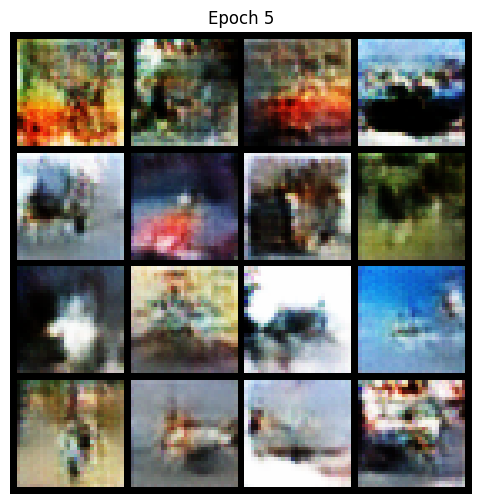

Epoch [6/25] Step [0/391] Loss D: 0.6479, Loss G: 2.5772
Epoch [6/25] Step [100/391] Loss D: 0.6652, Loss G: 2.0773
Epoch [6/25] Step [200/391] Loss D: 0.5954, Loss G: 2.3117
Epoch [6/25] Step [300/391] Loss D: 1.0663, Loss G: 5.0994


<Figure size 640x480 with 0 Axes>

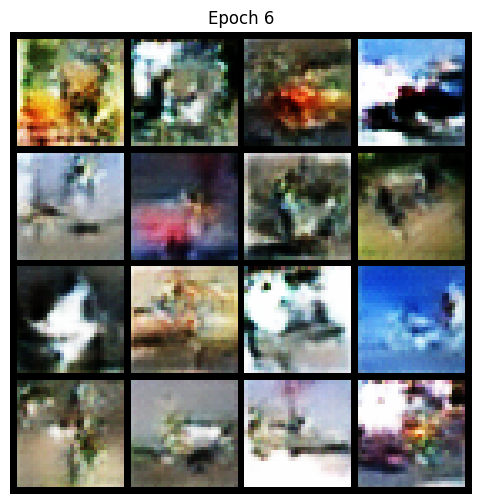

Epoch [7/25] Step [0/391] Loss D: 0.6385, Loss G: 2.9044
Epoch [7/25] Step [100/391] Loss D: 0.8688, Loss G: 1.9587
Epoch [7/25] Step [200/391] Loss D: 1.0952, Loss G: 2.5081
Epoch [7/25] Step [300/391] Loss D: 0.8548, Loss G: 4.1904


<Figure size 640x480 with 0 Axes>

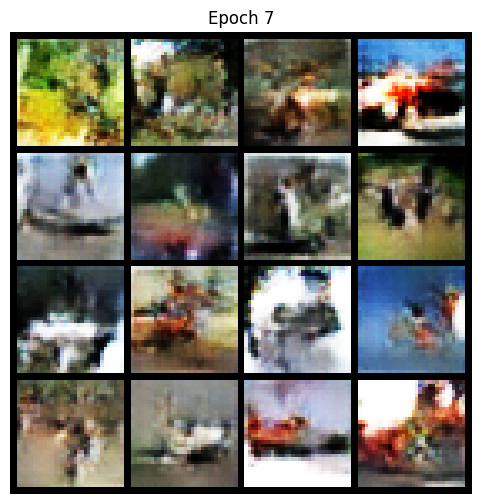

Epoch [8/25] Step [0/391] Loss D: 0.4654, Loss G: 2.4109
Epoch [8/25] Step [100/391] Loss D: 0.8960, Loss G: 6.1494
Epoch [8/25] Step [200/391] Loss D: 0.7363, Loss G: 0.2305
Epoch [8/25] Step [300/391] Loss D: 0.5531, Loss G: 3.1859


<Figure size 640x480 with 0 Axes>

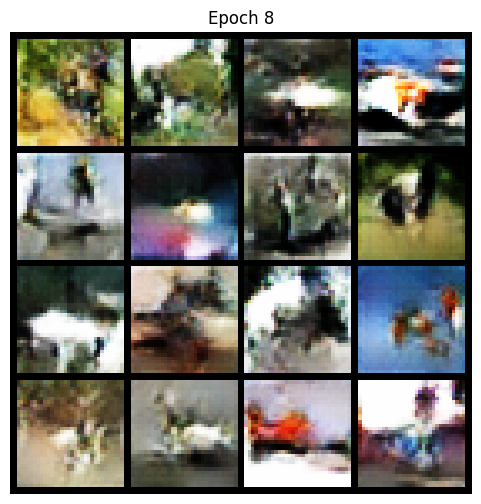

Epoch [9/25] Step [0/391] Loss D: 0.4158, Loss G: 2.5203
Epoch [9/25] Step [100/391] Loss D: 2.2371, Loss G: 1.0608
Epoch [9/25] Step [200/391] Loss D: 0.3410, Loss G: 2.6970
Epoch [9/25] Step [300/391] Loss D: 0.3142, Loss G: 2.7246


<Figure size 640x480 with 0 Axes>

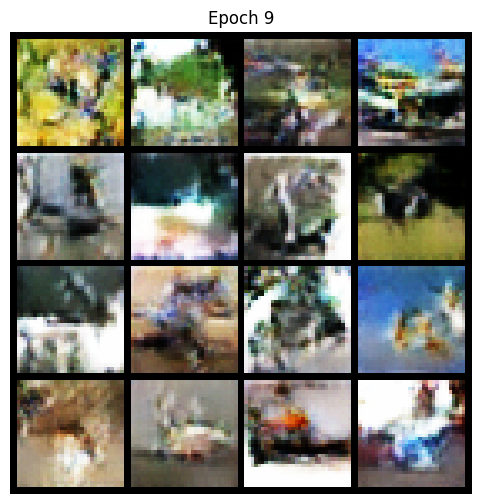

Epoch [10/25] Step [0/391] Loss D: 0.5577, Loss G: 2.0891
Epoch [10/25] Step [100/391] Loss D: 0.5645, Loss G: 2.1413
Epoch [10/25] Step [200/391] Loss D: 1.1880, Loss G: 1.1024
Epoch [10/25] Step [300/391] Loss D: 0.6952, Loss G: 4.2136


<Figure size 640x480 with 0 Axes>

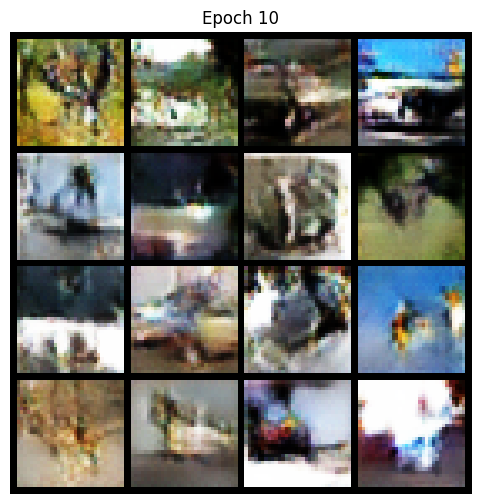

Epoch [11/25] Step [0/391] Loss D: 0.4315, Loss G: 3.0045
Epoch [11/25] Step [100/391] Loss D: 0.3785, Loss G: 2.5418
Epoch [11/25] Step [200/391] Loss D: 0.7785, Loss G: 1.8993
Epoch [11/25] Step [300/391] Loss D: 0.2627, Loss G: 2.9001


<Figure size 640x480 with 0 Axes>

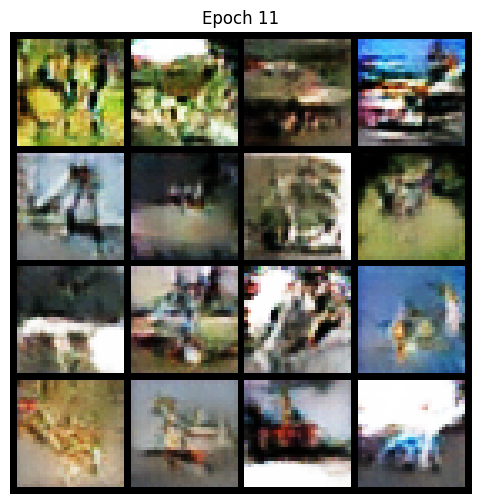

Epoch [12/25] Step [0/391] Loss D: 0.4949, Loss G: 3.9352
Epoch [12/25] Step [100/391] Loss D: 1.4242, Loss G: 6.8935
Epoch [12/25] Step [200/391] Loss D: 0.4795, Loss G: 3.4805
Epoch [12/25] Step [300/391] Loss D: 0.5965, Loss G: 3.5122


<Figure size 640x480 with 0 Axes>

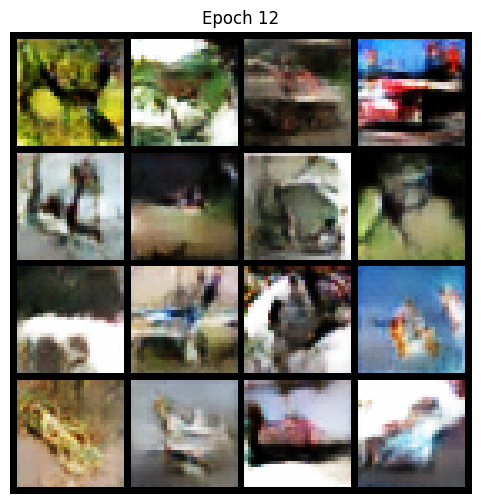

Epoch [13/25] Step [0/391] Loss D: 0.6410, Loss G: 1.9031
Epoch [13/25] Step [100/391] Loss D: 0.6296, Loss G: 2.1915
Epoch [13/25] Step [200/391] Loss D: 0.9320, Loss G: 4.8533
Epoch [13/25] Step [300/391] Loss D: 1.6860, Loss G: 7.5004


<Figure size 640x480 with 0 Axes>

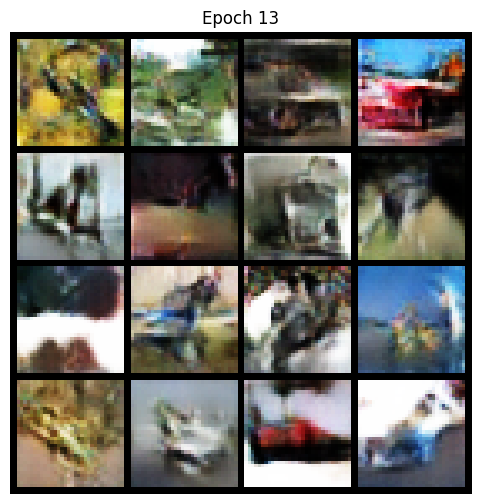

Epoch [14/25] Step [0/391] Loss D: 0.4825, Loss G: 2.8299
Epoch [14/25] Step [100/391] Loss D: 0.5966, Loss G: 2.0963
Epoch [14/25] Step [200/391] Loss D: 0.1889, Loss G: 3.0502
Epoch [14/25] Step [300/391] Loss D: 0.3900, Loss G: 2.5701


<Figure size 640x480 with 0 Axes>

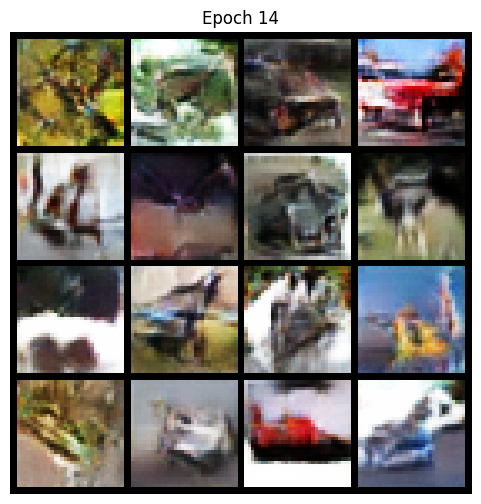

Epoch [15/25] Step [0/391] Loss D: 0.4762, Loss G: 1.7780
Epoch [15/25] Step [100/391] Loss D: 0.7633, Loss G: 3.8816
Epoch [15/25] Step [200/391] Loss D: 0.4802, Loss G: 3.0549
Epoch [15/25] Step [300/391] Loss D: 1.4536, Loss G: 1.2054


<Figure size 640x480 with 0 Axes>

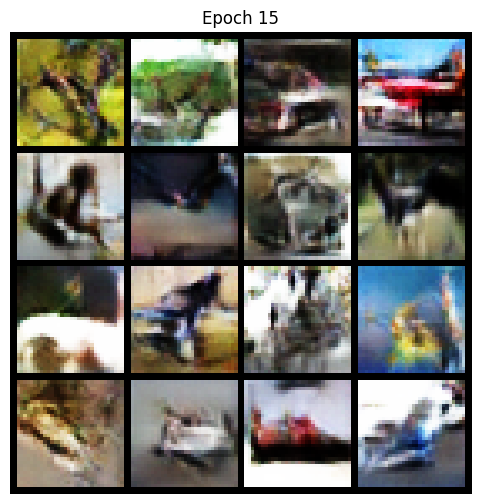

Epoch [16/25] Step [0/391] Loss D: 0.5043, Loss G: 2.7241
Epoch [16/25] Step [100/391] Loss D: 0.3099, Loss G: 3.6623
Epoch [16/25] Step [200/391] Loss D: 1.3520, Loss G: 6.5948
Epoch [16/25] Step [300/391] Loss D: 0.8703, Loss G: 1.3860


<Figure size 640x480 with 0 Axes>

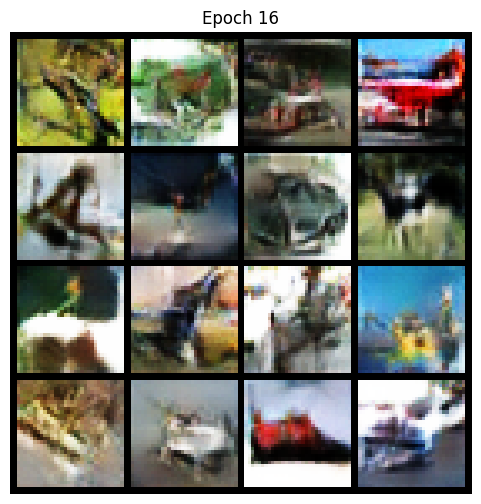

Epoch [17/25] Step [0/391] Loss D: 0.2733, Loss G: 3.1444
Epoch [17/25] Step [100/391] Loss D: 0.5472, Loss G: 2.4909
Epoch [17/25] Step [200/391] Loss D: 0.7832, Loss G: 5.6689
Epoch [17/25] Step [300/391] Loss D: 0.5433, Loss G: 5.1807


<Figure size 640x480 with 0 Axes>

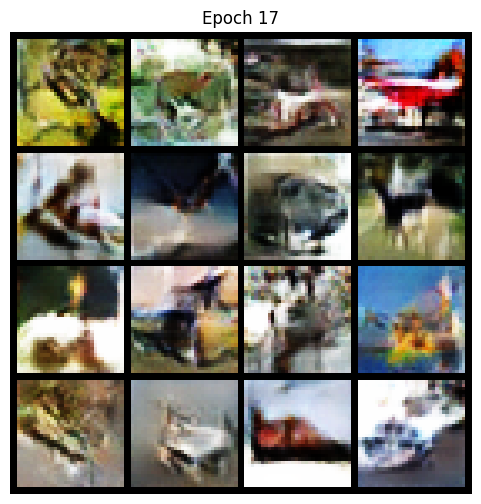

Epoch [18/25] Step [0/391] Loss D: 0.8901, Loss G: 3.7285
Epoch [18/25] Step [100/391] Loss D: 0.1510, Loss G: 2.9346
Epoch [18/25] Step [200/391] Loss D: 0.1520, Loss G: 3.7442
Epoch [18/25] Step [300/391] Loss D: 0.7593, Loss G: 1.5805


<Figure size 640x480 with 0 Axes>

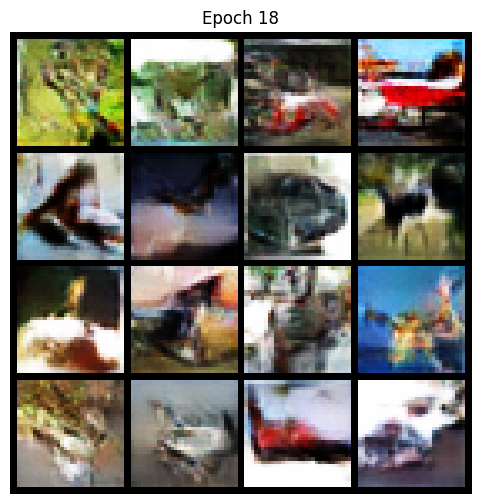

Epoch [19/25] Step [0/391] Loss D: 0.4470, Loss G: 1.6224
Epoch [19/25] Step [100/391] Loss D: 0.4018, Loss G: 2.2254
Epoch [19/25] Step [200/391] Loss D: 0.1333, Loss G: 3.0898
Epoch [19/25] Step [300/391] Loss D: 0.2548, Loss G: 3.4397


<Figure size 640x480 with 0 Axes>

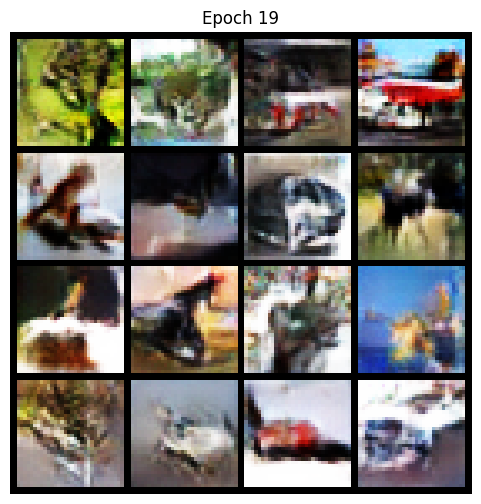

Epoch [20/25] Step [0/391] Loss D: 0.4482, Loss G: 3.0605
Epoch [20/25] Step [100/391] Loss D: 0.3508, Loss G: 1.9535
Epoch [20/25] Step [200/391] Loss D: 0.5488, Loss G: 3.6996
Epoch [20/25] Step [300/391] Loss D: 0.3772, Loss G: 2.2072


<Figure size 640x480 with 0 Axes>

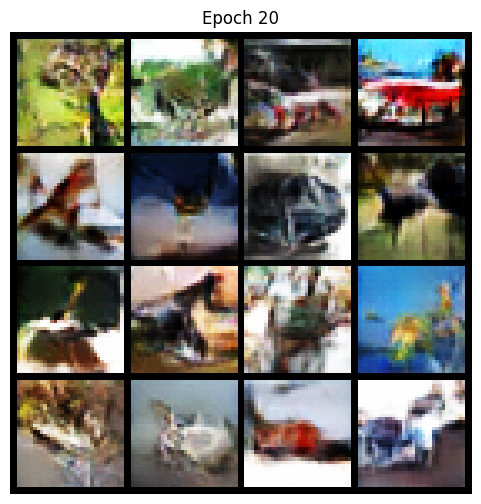

Epoch [21/25] Step [0/391] Loss D: 1.1241, Loss G: 5.9818
Epoch [21/25] Step [100/391] Loss D: 0.4783, Loss G: 3.4927
Epoch [21/25] Step [200/391] Loss D: 0.3394, Loss G: 3.3935
Epoch [21/25] Step [300/391] Loss D: 0.4637, Loss G: 2.7765


<Figure size 640x480 with 0 Axes>

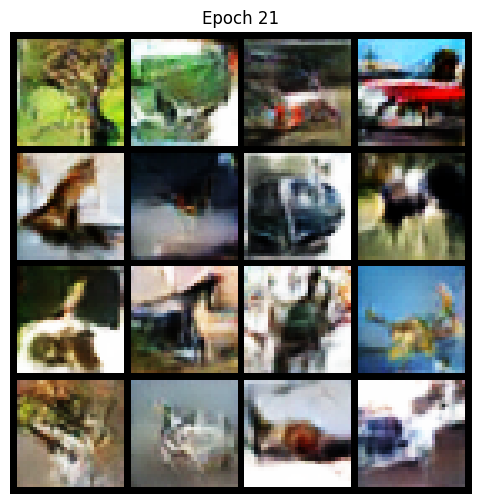

Epoch [22/25] Step [0/391] Loss D: 0.5337, Loss G: 4.2291
Epoch [22/25] Step [100/391] Loss D: 0.3123, Loss G: 2.7481
Epoch [22/25] Step [200/391] Loss D: 0.3705, Loss G: 3.9932
Epoch [22/25] Step [300/391] Loss D: 0.5106, Loss G: 4.1520


<Figure size 640x480 with 0 Axes>

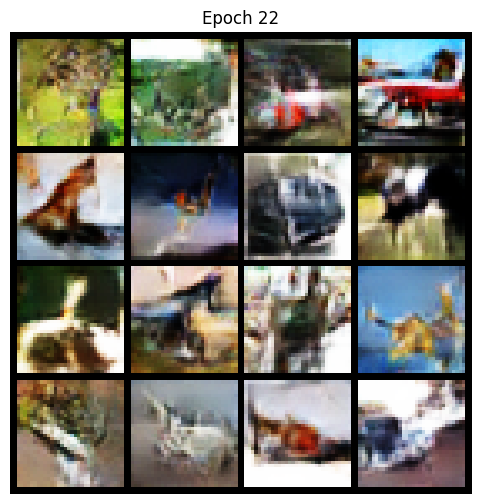

Epoch [23/25] Step [0/391] Loss D: 0.3001, Loss G: 3.4997
Epoch [23/25] Step [100/391] Loss D: 0.5411, Loss G: 1.9793
Epoch [23/25] Step [200/391] Loss D: 1.9029, Loss G: 0.9596
Epoch [23/25] Step [300/391] Loss D: 0.5584, Loss G: 5.9494


<Figure size 640x480 with 0 Axes>

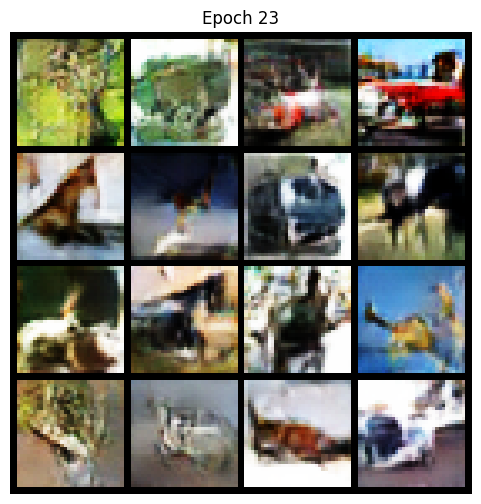

Epoch [24/25] Step [0/391] Loss D: 0.2620, Loss G: 3.6741
Epoch [24/25] Step [100/391] Loss D: 0.9501, Loss G: 5.2666
Epoch [24/25] Step [200/391] Loss D: 0.4075, Loss G: 2.6489
Epoch [24/25] Step [300/391] Loss D: 0.4339, Loss G: 4.0244


<Figure size 640x480 with 0 Axes>

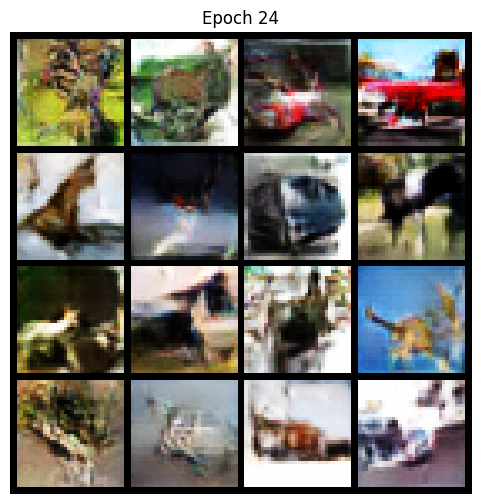

Epoch [25/25] Step [0/391] Loss D: 1.7616, Loss G: 5.2574
Epoch [25/25] Step [100/391] Loss D: 0.2573, Loss G: 3.3945
Epoch [25/25] Step [200/391] Loss D: 0.2019, Loss G: 3.2349
Epoch [25/25] Step [300/391] Loss D: 0.1483, Loss G: 3.3648


<Figure size 640x480 with 0 Axes>

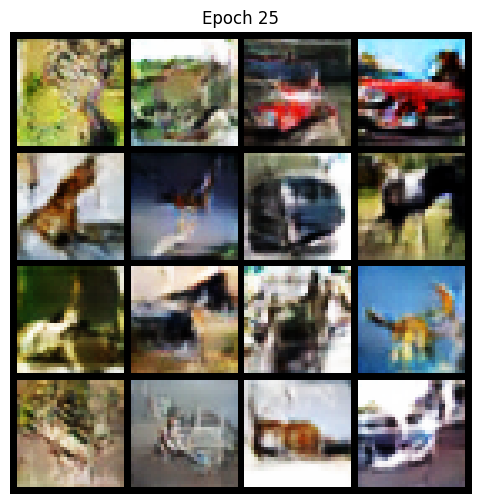

<Figure size 640x480 with 0 Axes>

In [13]:
# Train the DCGAN
train_dcgan()

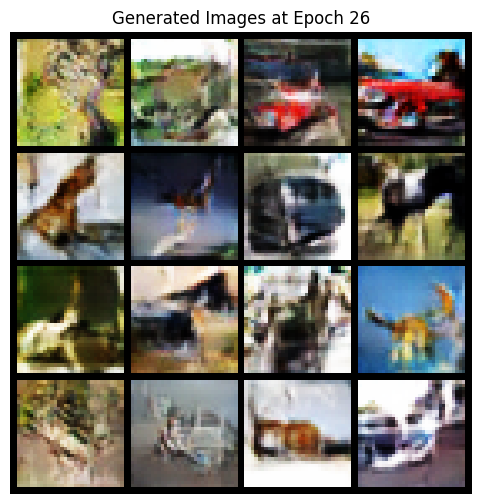

<Figure size 640x480 with 0 Axes>

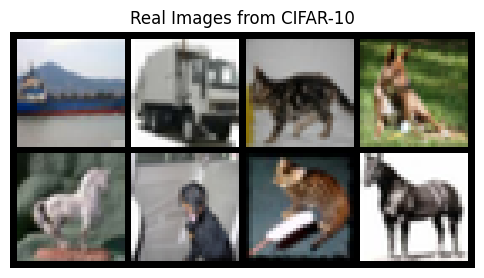

In [20]:
# Generate and visualize final output
with torch.no_grad():
    final_fake_images = generator(fixed_noise).cpu()
plot_generated_images(final_fake_images, epochs)
visualize_real_images()


**Conclusion**

In this implementation, we successfully trained a Deep Convolutional Generative Adversarial Network (DCGAN) on the CIFAR-10 dataset following the original DCGAN architecture proposed by Radford et al. (2016). The model effectively leveraged:

Strided and Fractionally-Strided Convolutions for learning spatial hierarchies.
Batch Normalization to stabilize training and prevent mode collapse.

LeakyReLU in the Discriminator for smoother gradient flow.

ReLU in the Generator with Tanh activation in the output layer for generating images in the correct range.

After 25 epochs of training, the Generator was able to produce realistic images that resembled CIFAR-10 samples.

The Discriminator effectively learned to distinguish real from fake images. Finally, we visualized both real and generated images, allowing for qualitative evaluation of the model’s progress.